In [1]:
import os
import numpy as np
import h5py

from matplotlib import pyplot as plt

In [2]:
os.chdir("/Users/jibanmac/Documents/GitHub/matter_emu_dgmgp/")

## How good you can infer this multi-fidelity power-law relation by using low-fidelity only??

What you can do:
1. Take LF SLHD training set, k-fold splitting and test on some of them (maybe 9 of them a batch).
2. Once you have the errors, do the inference again.
3. Try different boxsizes, and supposedly boxsize smaller the correlation higher (?)

The budget power-law relation of error(number of points) will be more useful if $\nu$ and $\eta$ can get from LF only emulator.

The way to test it is to train LF only emulator and test the accuracy.

Use the test accuracy as a function of LF points to get $\nu$.

To see how well it scales to MF case.

In this case $\eta$ might not be translatable? But in principle you can get the average error in some way 

In [3]:
# Load folder names
from matter_multi_fidelity_emu.data_loader import folder_name
from matter_multi_fidelity_emu.data_loader import PowerSpecs

In [4]:
# loading from folders
# change box size to see if optimal \rho change
box_list = [100, 128, 160, 192, 224, 256]
z_list   = [0, 0.2, 0.5, 1.0, 2.0, 3.0]

lf_train_dict = {
    "z_list" : z_list,
    "box_list" : box_list,
    "data" : {
    }
}

for box1 in box_list:
    boxkey = "box_{}".format(box1)
    lf_train_dict["data"][boxkey] = {}

    for z in z_list:
        lf_train_dict["data"][boxkey][str(z)] = {}

        # Matterpower_60_res128box{ }_3_res512box256_z{}_ind{}
        fname = folder_name(
            num1=60,
            res1=128,
            box1=box1,
            num2=3,
            res2=512,
            box2=256,
            z=z,
            selected_ind=[57, 58, 59],
        )

        fname = os.path.join("data/processed/", fname)

        # Just save different redshifts into different items
        power = PowerSpecs()
        power.read_from_txt(fname)

        # Save into dict for later use
        X = power.X_train_norm[0]
        Y = power.Y_train_norm[0]

        lf_train_dict["data"][boxkey][str(z)]["X"] = X
        lf_train_dict["data"][boxkey][str(z)]["Y"] = Y



## Train GP and get test error

Maybe test the workflow first on one boxsize

In [6]:
import GPy

What we need is to do a k-fold validation errors:
1. Slice the training data into k slices (require k-loops)
2. Select one of the slice as testing set,
3. Select some the rest slices as training set (looping over `num_train`)
4. Get testing errors

In [7]:
# Should do a k-fold validation
num_train     = [6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, ]
num_test      = 12
num_redshifts = len(lf_train_dict["z_list"])
# GP optimization options
n_optimization_restarts = 5
parallel = True


# query the boxsize you want
name_box_list = ["box_100", "box_128", "box_160", "box_192", "box_224", "box_256"]
num_boxes = len(name_box_list)


# Training options
_Y = lf_train_dict["data"]["box_100"]["0"]["Y"]
num_examples = _Y.shape[0]
num_folds    = num_examples // num_test


val_error_list = np.full((num_boxes, num_redshifts, num_folds, len(num_train), num_test, _Y.shape[1]), fill_value=np.nan)
val_pred_list  = np.full((num_boxes, num_redshifts, num_folds, len(num_train), num_test, _Y.shape[1]), fill_value=np.nan)


for _kth_box, name_box in enumerate(name_box_list):

    for _lth_z, z in enumerate(z_list):
        X = lf_train_dict["data"][name_box][str(z)]["X"]
        Y = lf_train_dict["data"][name_box][str(z)]["Y"]

        for _ith_fold in range(num_folds):

            # real values indices
            _real_test_idx  = np.arange(num_examples)[_ith_fold * num_test : (_ith_fold + 1) * num_test ]

            # Use boolean indices
            _test_ind = np.full(num_examples, fill_value=False, dtype=np.bool_)
            _test_ind[_real_test_idx] = True

            X_test = X[_test_ind]
            Y_test = Y[_test_ind]


            # loop over different number of training points
            for _jth_train, _n_train in enumerate(num_train):
                _real_train_idx = set(np.arange(num_examples)) - set(_real_test_idx)
                # Different number of training points
                _real_train_idx = np.array(list(_real_train_idx))[:_n_train]
                # Use boolean indicies
                _train_ind = np.full(num_examples, fill_value=False, dtype=np.bool_)
                _train_ind[_real_train_idx] = True

                X_train = X[_train_ind]
                Y_train = Y[_train_ind]


                _nparams = np.shape(X_train)[1]

                _kernel = GPy.kern.RBF(_nparams, ARD=True)            

                # same hyperparameters shared between bins
                _gp = GPy.models.GPRegression(X_train, Y_train, _kernel)
                _gp.optimize_restarts(n_optimization_restarts, parallel=parallel, verbose=False)

                (Y_pred, _var) = _gp.predict(X_test)


                _val_error = np.abs(  Y_pred/Y_test  - 1 )

                val_pred_list[ _kth_box, _lth_z, _ith_fold, _jth_train, :, :Y_pred.shape[1]]  = Y_pred
                val_error_list[ _kth_box, _lth_z, _ith_fold, _jth_train, :, :Y_pred.shape[1]] = _val_error



 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/jibanmac/Documents/conda/emu-3.9/lib/python3.9/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarn

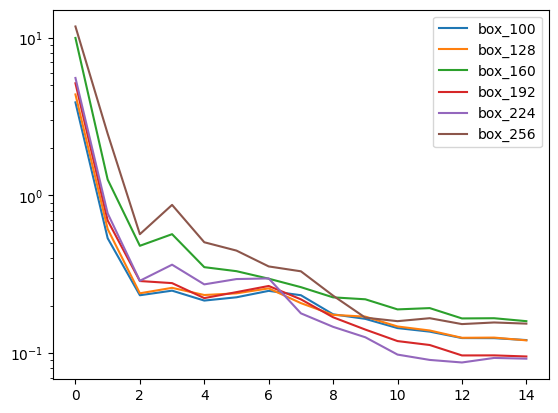

In [29]:
# num_boxes, num_redshifts, num_folds, len(num_train), num_test, _Y.shape[1]
for _kth_box in range(num_boxes):
    plt.semilogy(np.nanmean(val_error_list[_kth_box, :, :, : ,:, :], axis=(0, 1, 3, 4)), label=name_box_list[_kth_box])

plt.legend()

## Save into budget data for later inference

(6, 5, 15, 12, 117)

I want (num of boxes, num of redshifts, num of folds, num of train lf points, num of test points, num of bins)
converted to
(num of boxes, --, --, num of train lf points, --, --)

In [10]:
_error_averaged_k_bins =  np.nanmean(val_error_list, axis=-1)

# (num boxes, num_train_lf_points)
mean_error = np.nanmean(_error_averaged_k_bins, axis=(1, 2, 4))
std_error  = np.nanstd(_error_averaged_k_bins, axis=(1, 2, 4))

In [28]:
os.makedirs("budget_size/lf_only_errors/", exist_ok=True)


lf_error_dict = {
    "num_train" : num_train,
    "num_test"  : num_test,
    "name_box_list" : name_box_list,
    "mean_error" : mean_error,
    "std_error" : std_error,
    "val_pred_list": val_pred_list,
    "val_error_list" : val_error_list,
    "lf_train_dict" : lf_train_dict,
}

with h5py.File("budget_size/lf_only_errors/budget_lf_only.h5", "w") as f:
    # main data arrays
    f.create_dataset("mean_error", data=mean_error)
    f.create_dataset("std_error", data=std_error)

    f.create_dataset("val_pred_list", data=val_pred_list)
    f.create_dataset("val_error_list", data=val_error_list)

    # attributes
    f.attrs["num_train"]     = num_train
    f.attrs["z_list"]        = z_list
    f.attrs["name_box_list"] = name_box_list

    # training set
    g = f.create_group("lf_train_dict")

    # TODO: there might be a better way to do it
    for _boxkey, _boxvalues in lf_train_dict["data"].items():
        gg = g.create_group(_boxkey)
        for _zkey, _zvalues in lf_train_dict["data"][_boxkey].items():
            ggg = gg.create_group(_zkey)
            for key,values in lf_train_dict["data"][_boxkey][_zkey].items():
                ggg.create_dataset(key, data=values)